# Imports realizados

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

# Importando a tabela gerada no código R

In [56]:
df = pd.read_csv("apac_linfoma_unificado_unicas.csv", sep = ",", low_memory=False)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30612 entries, 0 to 30611
Data columns (total 65 columns):
Unnamed: 0         30612 non-null int64
X1                 30612 non-null int64
X                  30612 non-null int64
AP_MVM             30612 non-null int64
AP_CONDIC          30612 non-null object
AP_GESTAO          30612 non-null int64
AP_CODUNI          30612 non-null int64
AP_AUTORIZ         30612 non-null int64
AP_CMP             30612 non-null int64
AP_PRIPAL          30612 non-null int64
AP_VL_AP           30612 non-null float64
AP_UFMUN           30612 non-null int64
AP_TPUPS           30612 non-null int64
AP_TIPPRE          30612 non-null int64
AP_CNPJCPF         30612 non-null int64
AP_CNPJMNT         30612 non-null int64
AP_CNSPCN          30612 non-null object
AP_COIDADE         30612 non-null int64
AP_NUIDADE         30612 non-null int64
AP_SEXO            30612 non-null object
AP_RACACOR         30612 non-null int64
AP_MUNPCN          30612 non-null int64
AP_UFN

## Retirando estádio 0 e nulo da variável AP_ESTADI
AP_ESTADI = 0: O valor 0 não é usado em linfomas

In [58]:
print('Nro de linhas:', len(df))

Nro de linhas: 30612


In [59]:
df = df[~((df['AP_ESTADI'] == 0.0) | (df['AP_ESTADI'].isna()))]

In [60]:
print('Nro de linhas:', len(df))

Nro de linhas: 22887


## Retirando colunas não utilizadas

In [61]:
df.columns

Index(['Unnamed: 0', 'X1', 'X', 'AP_MVM', 'AP_CONDIC', 'AP_GESTAO',
       'AP_CODUNI', 'AP_AUTORIZ', 'AP_CMP', 'AP_PRIPAL', 'AP_VL_AP',
       'AP_UFMUN', 'AP_TPUPS', 'AP_TIPPRE', 'AP_CNPJCPF', 'AP_CNPJMNT',
       'AP_CNSPCN', 'AP_COIDADE', 'AP_NUIDADE', 'AP_SEXO', 'AP_RACACOR',
       'AP_MUNPCN', 'AP_UFNACIO', 'AP_CEPPCN', 'AP_UFDIF', 'AP_MNDIF',
       'AP_DTINIC', 'AP_DTFIM', 'AP_TPATEN', 'AP_TPAPAC', 'AP_MOTSAI',
       'AP_OBITO', 'AP_APACANT', 'AP_UNISOL', 'AP_DTSOLIC', 'AP_DTAUT',
       'AP_CIDCAS', 'AP_CIDPRI', 'AP_CIDSEC', 'AP_ESTADI', 'AP_DTIDEN',
       'AP_TRANTE', 'AP_DTINTR', 'QTD_MEDICOS', 'QTD_LEITOS', 'QTD_HESP',
       'QTD_HGERAL', 'QTD_CESP', 'QTD_UBS', 'QTD_UADT', 'UF', 'LO_P', 'LA_P',
       'LO_H', 'LA_H', 'DISTANCIA', 'MIN_VAL', 'MAX_VAL', 'MEAN_VAL',
       'NUM_APACS', 'MIN_DIST', 'MEAN_DIST', 'MAX_DIST', 'MEDIA_MES_ATEND',
       'NRO_DIF_HOSP'],
      dtype='object')

In [10]:
not_used_features = ['Unnamed: 0',
                  'X1', 
                  'X', 
                  'AP_CNPJCPF',  #CNPJ do Estabelecimento executante
                  'AP_CNPJMNT',  #CNPJ MANTENEDORA
                  'AP_CNSPCN',   #numero do CNS - chave usada
                  'AP_UFNACIO',  #Código de nacionalidade do paciente - 99,75% sao brasileiros (2a maior nacionalidade tem 30 instancias só)
                  'AP_TPATEN', 
                  'AP_TPAPAC', 
                  'AP_APACANT', 
                  'AP_VL_AP',
                  'AP_MVM', 
                  'AP_GESTAO',
                  'AP_AUTORIZ', 
                  'AP_CMP',
                  'AP_COIDADE',
                  'AP_CEPPCN', 
                  'AP_DTINIC', 
                  'AP_DTFIM',
                  'AP_UFMUN',
                  'AP_UNISOL', 
                  'AP_DTSOLIC', 
                  'AP_DTAUT', 
                  'AP_DTIDEN', 
                  'AP_MUNPCN',
                  'AP_CIDCAS', #CID de causas associadas 
                  'AP_CIDPRI', #CID de causa principal
                  'AP_CIDSEC', #CID de causa secudaria
                  'AP_TRANTE', 
                  'AP_DTINTR',
                  'AP_CODUNI', 
                  'AP_MNDIF', #Se a pessoa mudou de municipio para se trata - todos sao 1 
                  'LO_P', 
                  'LA_P',
                  'LO_H', 
                  'LA_H']

used_features = ['AP_CONDIC',
                 'AP_PRIPAL',
                 'AP_TPUPS',
                 'AP_TIPPRE',
                 'AP_NUIDADE', 
                 'AP_SEXO', 
                 'AP_RACACOR',
                 'AP_UFDIF',
                 'AP_MOTSAI',
                 'AP_OBITO',
                 'QTD_MEDICOS',
                 'QTD_LEITOS',
                 'QTD_HESP',
                 'QTD_HGERAL',
                 'QTD_CESP',
                 'QTD_UBS', 
                 'QTD_UADT', 
                 'UF', 
                 'MIN_VAL', 
                 'MAX_VAL', 
                 'MEAN_VAL',
                 'NUM_APACS', 
                 'MEDIA_MES_ATEND', 
                 'MIN_DIST', 
                 'MEAN_DIST', 
                 'MAX_DIST', 
                 'NRO_DIF_HOSP',
                 'DISTANCIA',
                 'AP_ESTADI']

In [11]:
df = df[used_features]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22887 entries, 0 to 30611
Data columns (total 29 columns):
AP_CONDIC          22887 non-null object
AP_PRIPAL          22887 non-null int64
AP_TPUPS           22887 non-null int64
AP_TIPPRE          22887 non-null int64
AP_NUIDADE         22887 non-null int64
AP_SEXO            22887 non-null object
AP_RACACOR         22887 non-null int64
AP_UFDIF           22887 non-null int64
AP_MOTSAI          22887 non-null int64
AP_OBITO           22887 non-null int64
QTD_MEDICOS        22887 non-null float64
QTD_LEITOS         22887 non-null float64
QTD_HESP           22887 non-null float64
QTD_HGERAL         22887 non-null float64
QTD_CESP           22887 non-null float64
QTD_UBS            22887 non-null float64
QTD_UADT           22887 non-null float64
UF                 22887 non-null object
MIN_VAL            22887 non-null float64
MAX_VAL            22887 non-null float64
MEAN_VAL           22887 non-null float64
NUM_APACS          22887 non

## Análise categóricas e numéricas

In [14]:
categoricals = ['AP_CONDIC', 'AP_PRIPAL', 'AP_TPUPS', 'AP_TIPPRE', 'AP_SEXO', 
                'AP_RACACOR', 'AP_UFDIF', 'AP_MOTSAI', 'AP_OBITO',
                'UF', 'AP_ESTADI']
numericals = ['AP_NUIDADE', 'QTD_MEDICOS', 'QTD_LEITOS', 'QTD_HESP', 
              'QTD_HGERAL', 'QTD_CESP','QTD_UBS', 'QTD_UADT', 'MIN_VAL', 'MAX_VAL', 
              'MEAN_VAL','NUM_APACS', 'MEDIA_MES_ATEND','MIN_DIST', 'MEAN_DIST', 'MAX_DIST', 
              'NRO_DIF_HOSP', 'DISTANCIA']

### Transformando as variávels categóricas em tipo object

In [17]:
dicCols = {}
for elem in categoricals:
    dicCols[elem] = object
df = df.astype(dicCols)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22887 entries, 0 to 30611
Data columns (total 29 columns):
AP_CONDIC          22887 non-null object
AP_PRIPAL          22887 non-null object
AP_TPUPS           22887 non-null object
AP_TIPPRE          22887 non-null object
AP_NUIDADE         22887 non-null int64
AP_SEXO            22887 non-null object
AP_RACACOR         22887 non-null object
AP_UFDIF           22887 non-null object
AP_MOTSAI          22887 non-null object
AP_OBITO           22887 non-null object
QTD_MEDICOS        22887 non-null float64
QTD_LEITOS         22887 non-null float64
QTD_HESP           22887 non-null float64
QTD_HGERAL         22887 non-null float64
QTD_CESP           22887 non-null float64
QTD_UBS            22887 non-null float64
QTD_UADT           22887 non-null float64
UF                 22887 non-null object
MIN_VAL            22887 non-null float64
MAX_VAL            22887 non-null float64
MEAN_VAL           22887 non-null float64
NUM_APACS          22

In [19]:
# numerical variables
df[numericals].describe()

,AP_NUIDADE,QTD_MEDICOS,QTD_LEITOS,QTD_HESP,QTD_HGERAL,QTD_CESP,QTD_UBS,QTD_UADT,MIN_VAL,MAX_VAL,MEAN_VAL,NUM_APACS,MEDIA_MES_ATEND,MIN_DIST,MEAN_DIST,MAX_DIST,NRO_DIF_HOSP,DISTANCIA
count,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000
mean,49.765369,4184.189122,1971.994735,10.151934,18.919098,401.012856,72.399881,110.026763,521.813358,1494.025359,1097.190658,6.409534,0.165456,62.705913,65.387725,69.508812,1.025691,64.573926
std,20.684912,9671.943938,3874.898076,19.449986,38.928353,877.613601,118.592908,204.871976,866.603366,1145.827860,866.941782,4.658318,0.386350,150.729207,154.990619,171.284969,0.161497,156.049548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,33.000000,35.750000,50.000000,0.000000,1.000000,5.000000,9.000000,4.000000,0.000000,800.000000,640.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,348.923077,251.714286,1.000000,3.000000,39.111111,25.000000,21.187500,0.000000,1258.640000,909.166667,6.000000,0.000000,15.523630,17.000959,17.357965,1.000000,16.414791
75%,66.000000,2263.944444,1330.083333,8.571429,13.000000,205.888889,72.585714,85.000000,800.000000,1700.000000,1270.605000,8.000000,0.166667,69.311742,73.226164,75.495543,1.000000,71.807723
max,99.000000,41820.000000,15710.000000,104.000000,151.000000,4190.000000,572.000000,869.000000,11644.000000,13620.000000,12224.666667,60.000000,3.000000,3090.945680,3090.945680,3518.604787,3.000000,3518.604787


In [20]:
df[categoricals].describe()

,AP_CONDIC,AP_PRIPAL,AP_TPUPS,AP_TIPPRE,AP_SEXO,AP_RACACOR,AP_UFDIF,AP_MOTSAI,AP_OBITO,UF,AP_ESTADI
count,22887,22887,22887,22887,22887,22887,22887,22887,22887,22887,22887
unique,3,27,5,7,2,6,2,16,2,26,4
top,PG,304060224,5,0,M,1,0,21,0,SP,3
freq,11616,5436,14919,18527,12445,11299,22349,20986,22556,4756,6954


### Heatmap da variávels numéricas

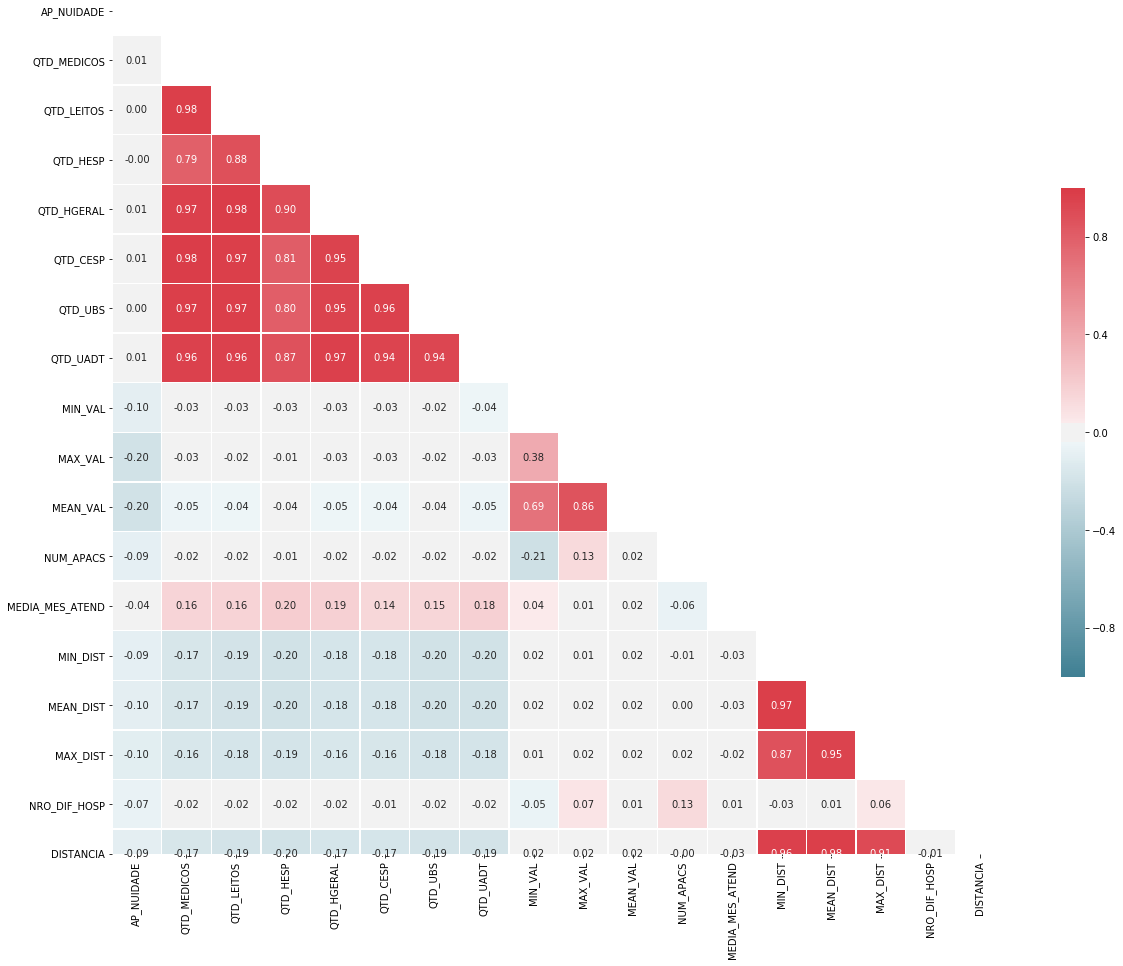

In [23]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# calculate the correlation matrix
corr = df[numericals].corr()

# calculate reduced correlation matrix
#corr_red = corr.filter(like='views',axis=0).filter(like='views',axis=1)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
df.head()

,AP_CONDIC,AP_PRIPAL,AP_TPUPS,AP_TIPPRE,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_UFDIF,AP_MOTSAI,AP_OBITO,...,MAX_VAL,MEAN_VAL,NUM_APACS,MEDIA_MES_ATEND,MIN_DIST,MEAN_DIST,MAX_DIST,NRO_DIF_HOSP,DISTANCIA,AP_ESTADI
0,PG,304070017,5,30,14,F,3,0,21,0,...,2571.00,1920.142857,7,0.142857,0.000000,0.000000,0.000000,1,0.000000,2
1,PG,304010294,5,30,15,M,99,0,21,0,...,3614.00,2994.000000,2,0.000000,23.875931,23.875931,23.875931,1,23.875931,3
2,PG,304060011,5,30,30,F,3,0,21,0,...,3054.00,1799.525000,8,0.125000,226.720580,226.720580,226.720580,1,226.720580,2
3,PG,304060011,5,30,38,M,3,0,21,0,...,2129.64,1992.831111,9,0.222222,0.000000,0.000000,0.000000,1,0.000000,2
4,PG,304010294,5,30,8,M,3,0,21,0,...,1724.00,1319.333333,3,0.000000,102.733028,102.733028,102.733028,1,102.733028,2


In [25]:
df.to_csv('base_unificada_limpa.csv', encoding='utf-8', index=False)

## Feature Ranking

In [26]:
data = pd.get_dummies(df)
print('Nro de colunas antes = ', len(df.columns))
print('Nro de colunas = ', len(data.columns))

Nro de colunas antes =  29
Nro de colunas =  118


## A célula abaixo define a coluna a Target Variable (AP_ESTADI_2)

In [62]:
estadi = 'AP_ESTADI_2'
col_estadi = list(data.columns).index(estadi)
print(col_estadi)
data.columns[col_estadi]

115


'AP_ESTADI_2'

### Feature ranking com Univariate Selection

In [29]:
X = data.iloc[:,0:-4]  #removendo as colunas referentes ao estadiamento
y = data.iloc[:,col_estadi] # coluna do estadiamento = 1

In [30]:
#Aplica o algoritmo SelectKBest para extrair as 15 melhores features utilizando chi-squared
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                  Specs         Score
1           QTD_MEDICOS  2.184237e+06
2            QTD_LEITOS  4.215433e+05
5              QTD_CESP  1.329057e+05
9               MAX_VAL  4.783161e+04
7              QTD_UADT  3.446320e+04
10             MEAN_VAL  3.108739e+04
8               MIN_VAL  2.802834e+04
6               QTD_UBS  1.469588e+04
17            DISTANCIA  1.219930e+04
14            MEAN_DIST  1.121559e+04
13             MIN_DIST  1.114169e+04
15             MAX_DIST  9.906682e+03
4            QTD_HGERAL  4.867721e+03
0            AP_NUIDADE  2.109334e+03
29  AP_PRIPAL_304060011  2.370769e+02


### Feature ranking com ExtraTreesClassifier

[5.91820204e-02 5.04862295e-02 4.69752074e-02 2.89499360e-02
 3.76879382e-02 4.78753419e-02 4.56502885e-02 4.66751653e-02
 2.94517044e-02 3.50784869e-02 4.59412513e-02 4.59308671e-02
 2.70376594e-02 2.76707623e-02 2.80592837e-02 2.79110852e-02
 5.53337212e-03 2.71287161e-02 7.94163627e-03 1.88367345e-03
 8.77920514e-03 3.69941000e-04 5.13055969e-05 4.43213423e-03
 4.67775395e-03 6.13800540e-03 4.21713337e-03 4.15480088e-03
 1.44262139e-03 1.39512089e-02 4.03749624e-03 2.17298554e-03
 2.53436450e-03 1.70460954e-04 1.29299784e-04 9.90595150e-05
 4.42772919e-03 2.31000930e-03 9.63671869e-03 1.06838439e-02
 8.58750382e-05 4.25138781e-06 6.98494887e-03 9.04771717e-04
 1.08907164e-04 3.61654714e-04 3.07951460e-04 1.55884881e-04
 7.63563540e-03 8.01688644e-03 4.74404826e-04 5.61178173e-04
 4.12670461e-06 9.04477593e-03 1.85912579e-04 3.38533854e-03
 4.01565968e-03 8.31380304e-04 4.07236188e-03 4.60713159e-03
 1.63179147e-02 1.63736407e-02 1.03560209e-02 4.11072246e-03
 1.05585371e-02 1.892679

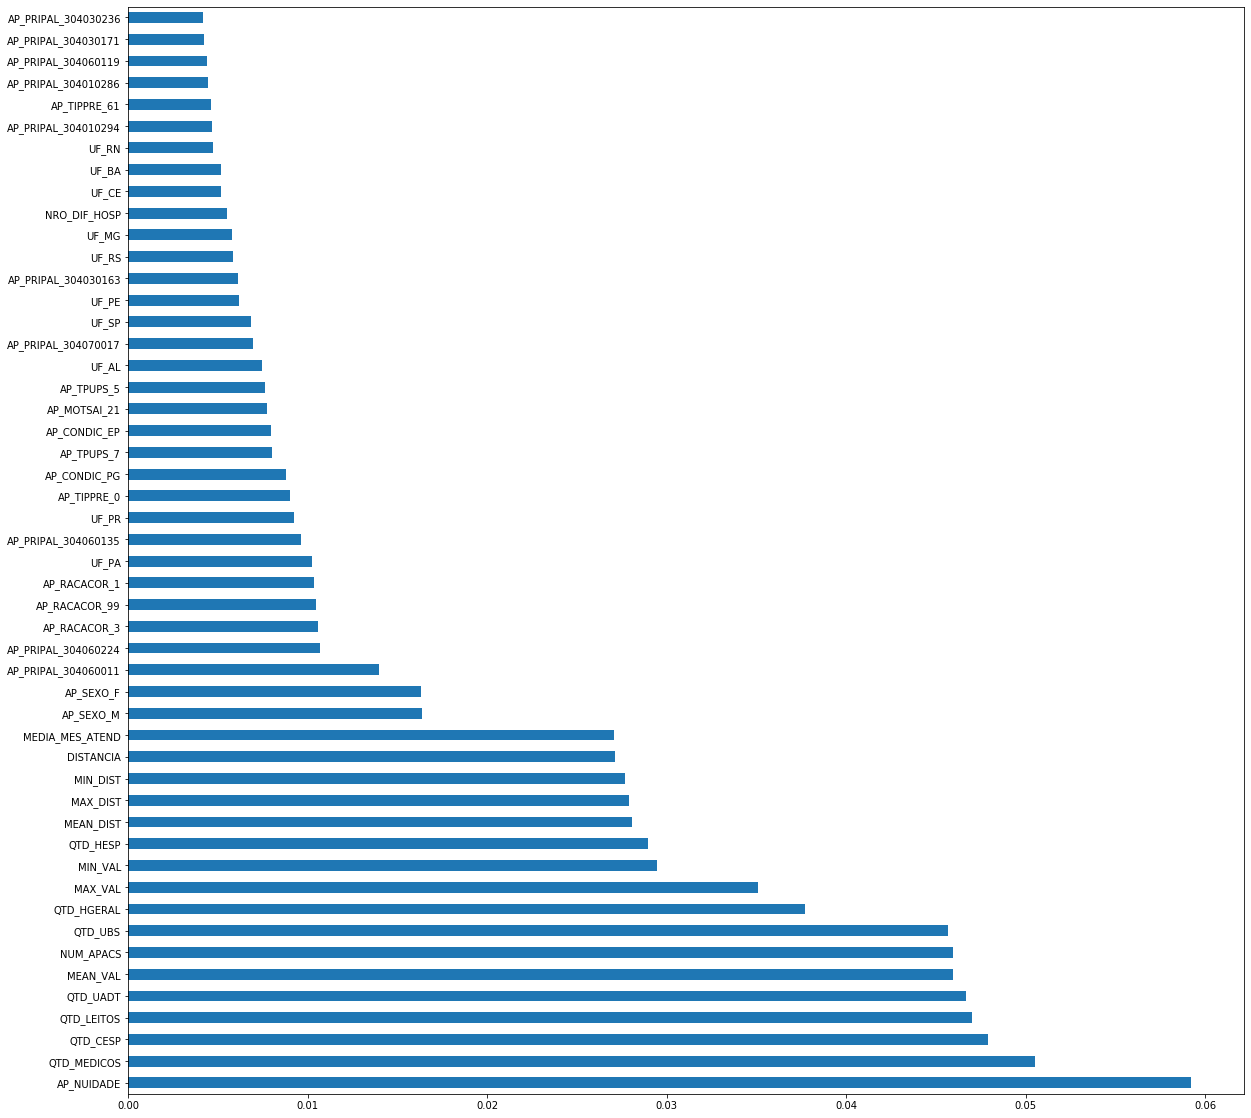

In [31]:
data = pd.get_dummies(df)

X = data.iloc[:,0:-4]  #removendo as colunas referentes ao estadiamento
y = data.iloc[:,col_estadi] # coluna do estadiamento = 1

model = ExtraTreesClassifier(n_estimators=100)
model.fit(X,y)
#Utiliza a feature importance dos classificadores
print(model.feature_importances_) 

#Plot do gráfico com as melhores features
plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()

### Feature ranking com RF e XgBoost


####  Train/Test Splitting 

In [32]:
# Cria o dataset com one hot encoding
dummy_df = pd.get_dummies(df)

In [33]:
df.shape

(22887, 29)

In [34]:
dummy_df.shape

(22887, 118)

In [36]:
# divide o dataset entre treino e teste
train_df = dummy_df.sample(frac=0.7, random_state=14)
test_df  = dummy_df.drop(train_df.index)

In [37]:
print('Train: ',train_df.shape)
print('Test: ', test_df.shape)

Train:  (16021, 118)
Test:  (6866, 118)


### Random Forest

In [38]:
X_train = train_df.iloc[:,0:-4]  #removendo as colunas referentes ao estadiamento
y_train = train_df.iloc[:,col_estadi] # coluna do estadiamento = 1

X_test = test_df.iloc[:,0:-4] #removendo as colunas referentes ao estadiamento
y_test = test_df.iloc[:,col_estadi] # coluna do estadiamento = 1

# Nomes das colunas
columns = test_df.drop(['AP_ESTADI_1','AP_ESTADI_2', 'AP_ESTADI_3','AP_ESTADI_4'], axis=1).columns.tolist()

In [39]:
rf = RandomForestClassifier(n_estimators=100) 
rf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns,
                                columns=['importance']).sort_values('importance',ascending=False)
print(feat_importances[0:15])

AP_NUIDADE         0.059182
QTD_MEDICOS        0.050486
QTD_LEITOS         0.046975
QTD_HESP           0.028950
QTD_HGERAL         0.037688
QTD_CESP           0.047875
QTD_UBS            0.045650
QTD_UADT           0.046675
MIN_VAL            0.029452
MAX_VAL            0.035078
MEAN_VAL           0.045941
NUM_APACS          0.045931
MEDIA_MES_ATEND    0.027038
MIN_DIST           0.027671
MEAN_DIST          0.028059
dtype: float64


### XgBoost

In [41]:
X_train = train_df.iloc[:,0:-4]  #removendo as colunas referentes ao estadiamento
y_train = train_df.iloc[:,col_estadi] # coluna do estadiamento = 1

X_test = test_df.iloc[:,0:-4] #removendo as colunas referentes ao estadiamento
y_test = test_df.iloc[:,col_estadi] # coluna do estadiamento = 1

# Nomes das colunas
columns = test_df.drop(['AP_ESTADI_1','AP_ESTADI_2', 'AP_ESTADI_3','AP_ESTADI_4'], axis=1).columns.tolist()

In [70]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=columns)
dtest = xgb.DMatrix(X_test, y_test, feature_names=columns)

### Definindo uma função de f1-score para ser maximizada pelo algoritmo XgBoost

In [46]:
def f1(labels,pred):
    p, r, t = precision_recall_curve(labels, pred)
    f1 = pd.Series((2*p*r)/(p+r))
    return 'F1-Score', f1.max(), t[f1.idxmax()]

def xgBoost_f1(pred,t):
    labels = t.get_label()
    name, val, thres = f1(labels,pred)
    return name, val

In [47]:
# função a ser minimizada
def score(params):
    print("Training with params: ")
    print(params)
    
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=columns)
    dtest = xgb.DMatrix(X_test, y_test, feature_names=columns)
    bst = xgb.train(
        verbose_eval=50,
        params=params, 
        dtrain=dtrain,
        num_boost_round=1000, 
        early_stopping_rounds=50, 
        evals=[(dtrain, 'train'), (dtest, 'test')],
        maximize=True, 
        feval=xgBoost_f1
    )
    predictions = bst.predict(dtest)
    
    #Para F1-Score
    name, score, thres = f1(y_test, predictions)
    print("\tScore {0}".format(score))
    
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

### Utilizando a biblioteca Hyperopt para otimizar os hyperparâmetros do XgBoost
### A função a ser minimizada é 1 - (f1-measure)

In [ ]:
"""
This is the optimization function that given a space of 
hyperparameters and a scoring function, finds the best hyperparameters.
"""

trials = Trials()  

space = {
    # parâmetros fixos
    'grow_policy': 'lossguide',
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'nthread' : 4,
    'max_depth': 0,
    'eval_metric': 'auc',

    # parâmetros variáveis
    'n_estimators': hp.quniform('n_estimators', 50, 200, 50),
    'eta': hp.quniform('eta', 0.1, 0.3, 0.1),
    'gamma': hp.quniform('gamma', 0., 0.3, 0.1),
    'max_bin': hp.choice('max_bin', np.arange(50, 250, 50, dtype=int)),
    'max_leaves': hp.choice('max_leaves', np.arange(100,260,40))

}

best = fmin(score, space, trials=trials, algo=tpe.suggest, max_evals=500)

In [44]:
# melhores hyperparâmetros encontrados
params = {'eta': 0.1, 'eval_metric': 'auc', 'gamma': 0.30000000000000004, 'grow_policy': 'lossguide', 'max_bin': 150, 'max_depth': 0, 'max_leaves': 100, 'n_estimators': 200.0, 'nthread': 4, 'objective': 'binary:logistic', 'tree_method': 'hist'}

In [48]:
# xgboost matrices & model training
dtrain = xgb.DMatrix(X_train, y_train, feature_names=columns)
dtest  = xgb.DMatrix(X_test, y_test, feature_names=columns)
bst = xgb.train(
    params=params, 
    dtrain=dtrain,
    verbose_eval=50,
    num_boost_round=5000, 
    early_stopping_rounds=100,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    maximize=True,
    feval=xgBoost_f1
)

[0]	train-auc:0.727315	test-auc:0.679865	train-F1-Score:0.502139	test-F1-Score:0.462205
Multiple eval metrics have been passed: 'test-F1-Score' will be used for early stopping.

Will train until test-F1-Score hasn't improved in 100 rounds.
[50]	train-auc:0.915115	test-auc:0.71154	train-F1-Score:0.731605	test-F1-Score:0.485316
[100]	train-auc:0.969648	test-auc:0.709964	train-F1-Score:0.85113	test-F1-Score:0.48251
[150]	train-auc:0.987096	test-auc:0.707229	train-F1-Score:0.909323	test-F1-Score:0.479779
Stopping. Best iteration:
[67]	train-auc:0.9389	test-auc:0.713514	train-F1-Score:0.776483	test-F1-Score:0.488508



In [49]:
# Obtendo as predições do modelo
y_pred = bst.predict(dtest)

In [50]:
# Computando a curva ROC do modelo
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

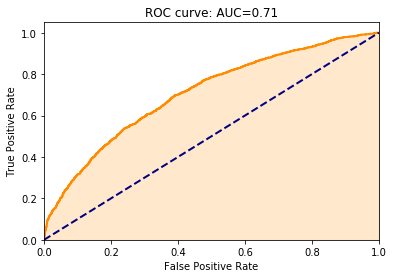

In [52]:
# Plotando a curva ROC do modelo
fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr,tpr, alpha=0.2, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve: AUC={0:0.2f}'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Calculando a features importance das variáveis com relação ao ganho, ganho total e peso
__weight__ é o número de vezes que um atributo foi escolhido em cada split.

__gain__ é o ganho médio de uma variável.

__total_gain__ é o ganho total de uma variável em todos os splits para todas as árvores do ensemble.

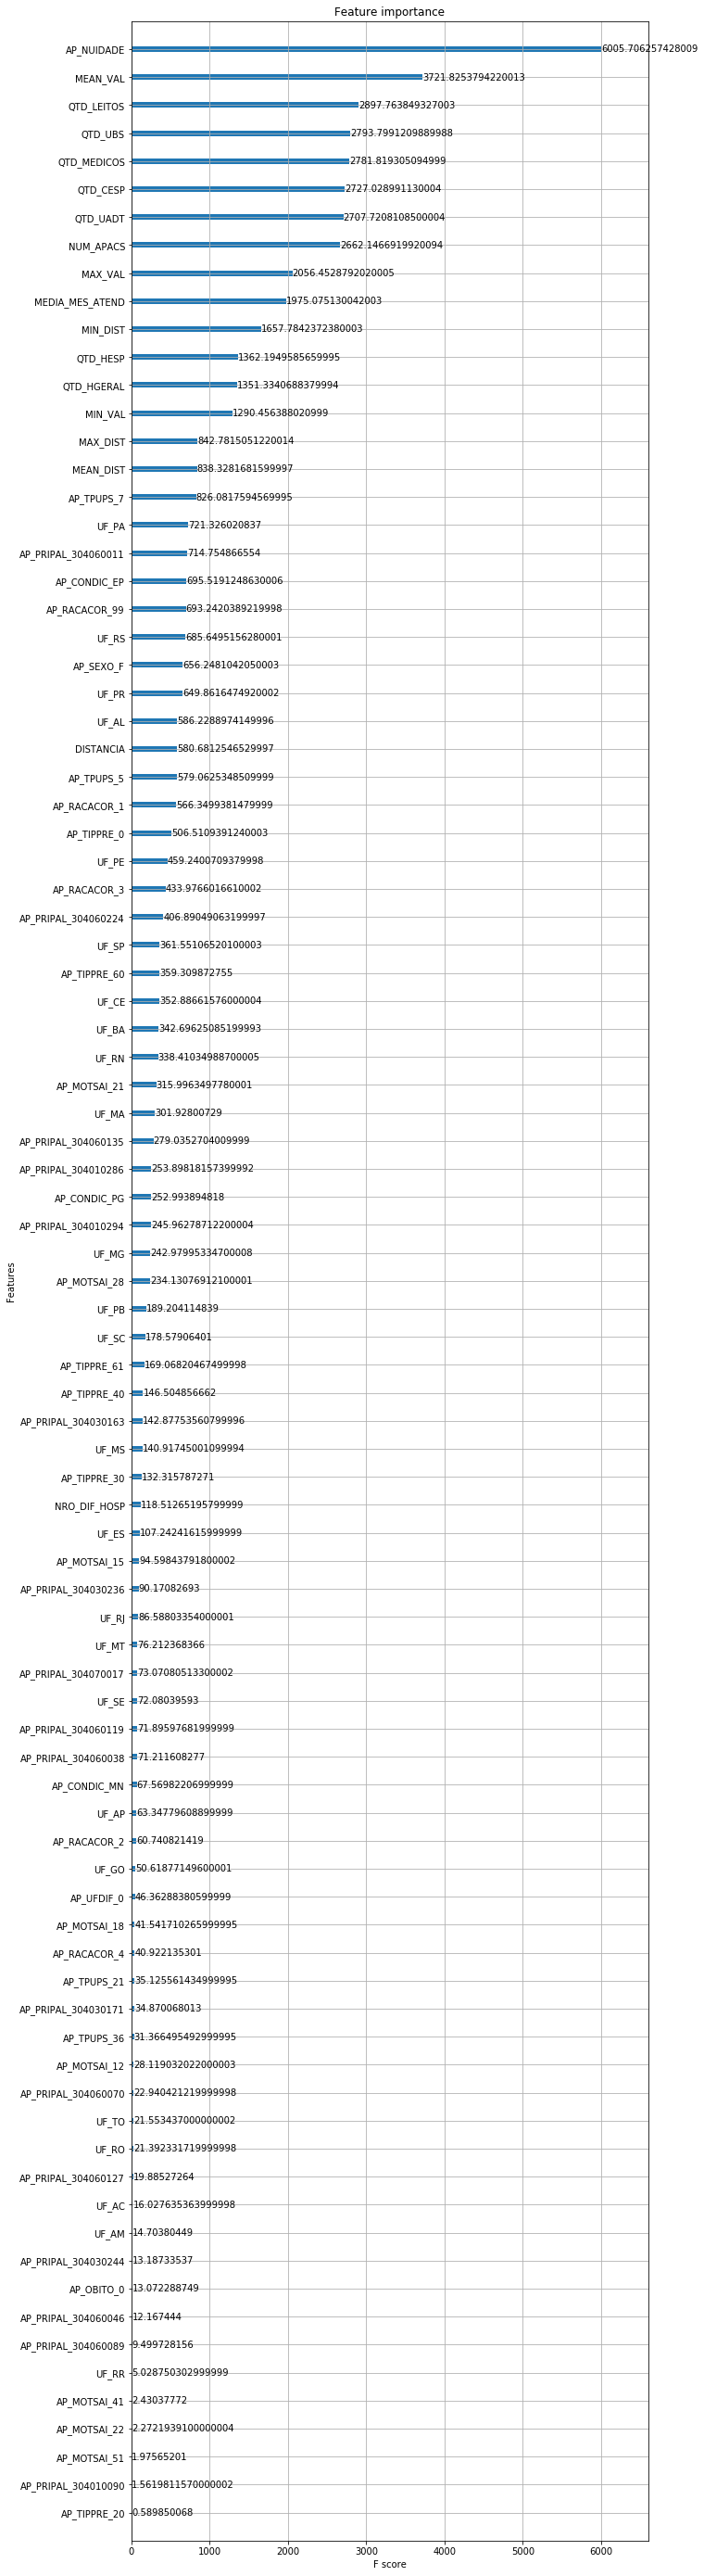

In [90]:
# Para ganho total
ax = xgb.plot_importance(bst, importance_type='total_gain')
fig = ax.figure
fig.set_size_inches(10, 50)

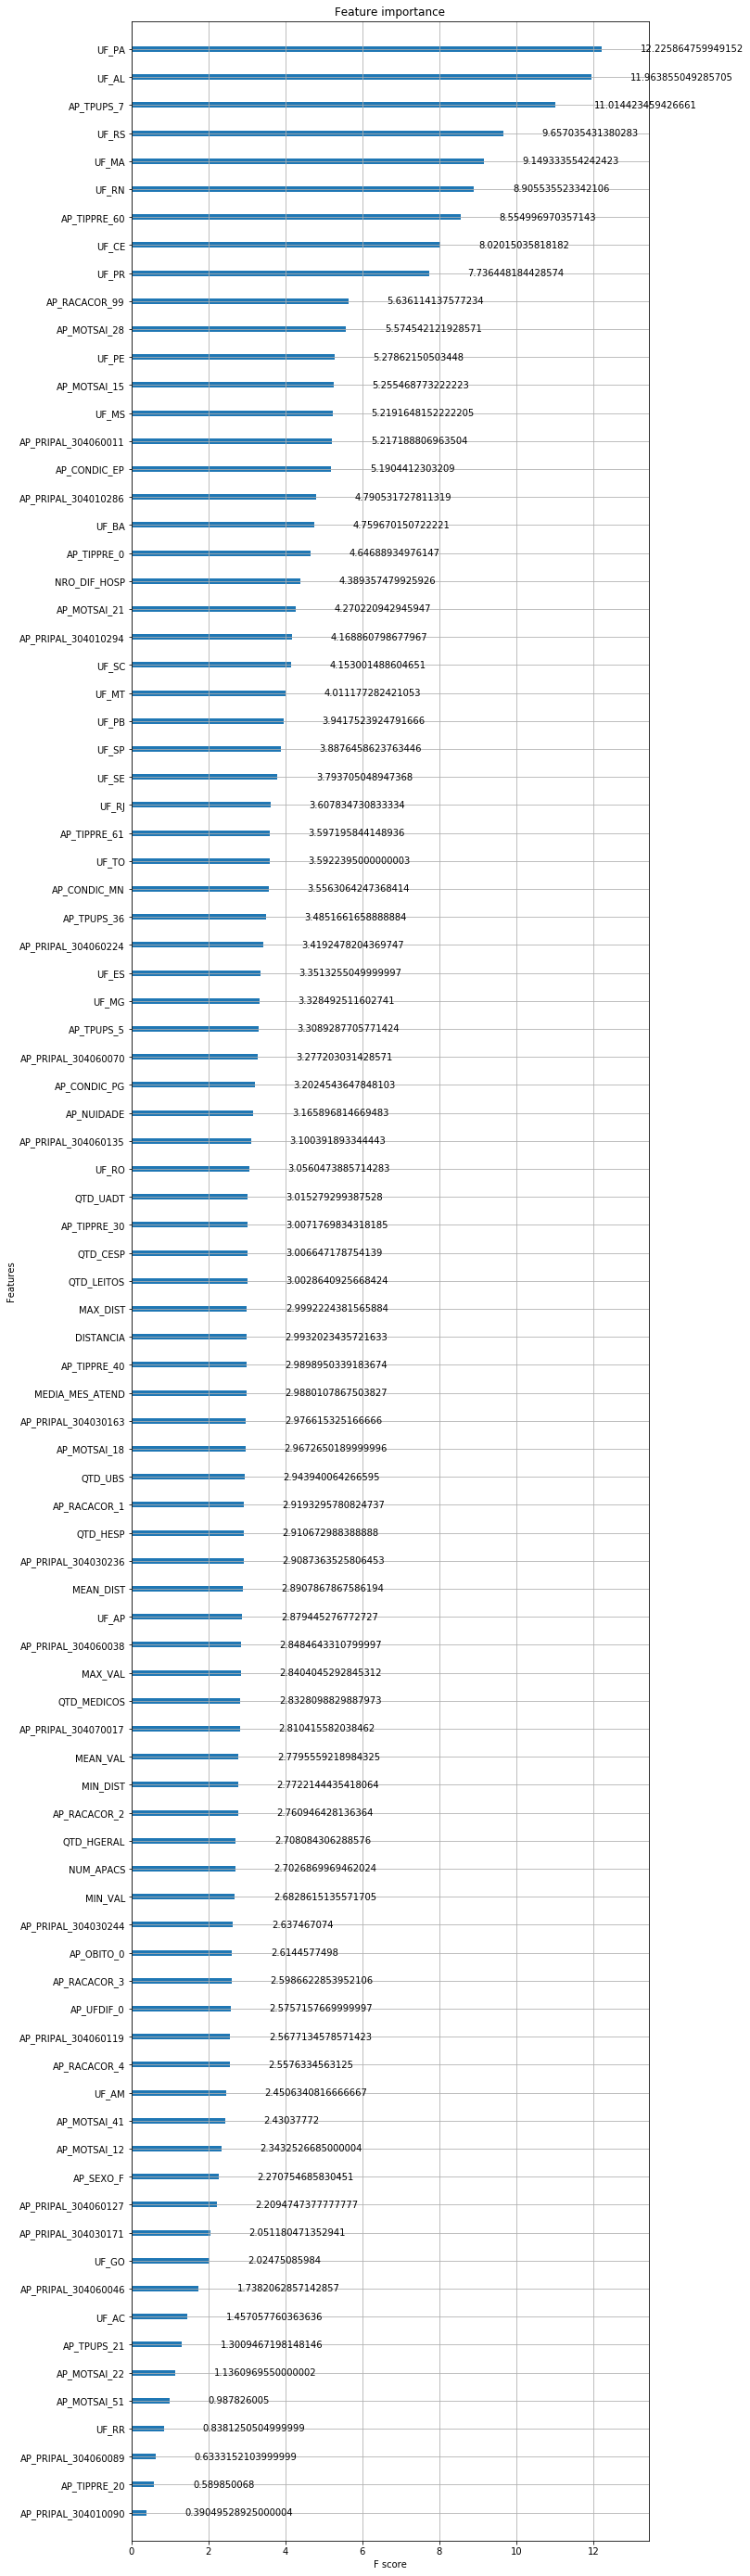

In [91]:
# Para ganho médio
ax = xgb.plot_importance(bst, importance_type='gain')
fig = ax.figure
fig.set_size_inches(10, 50)

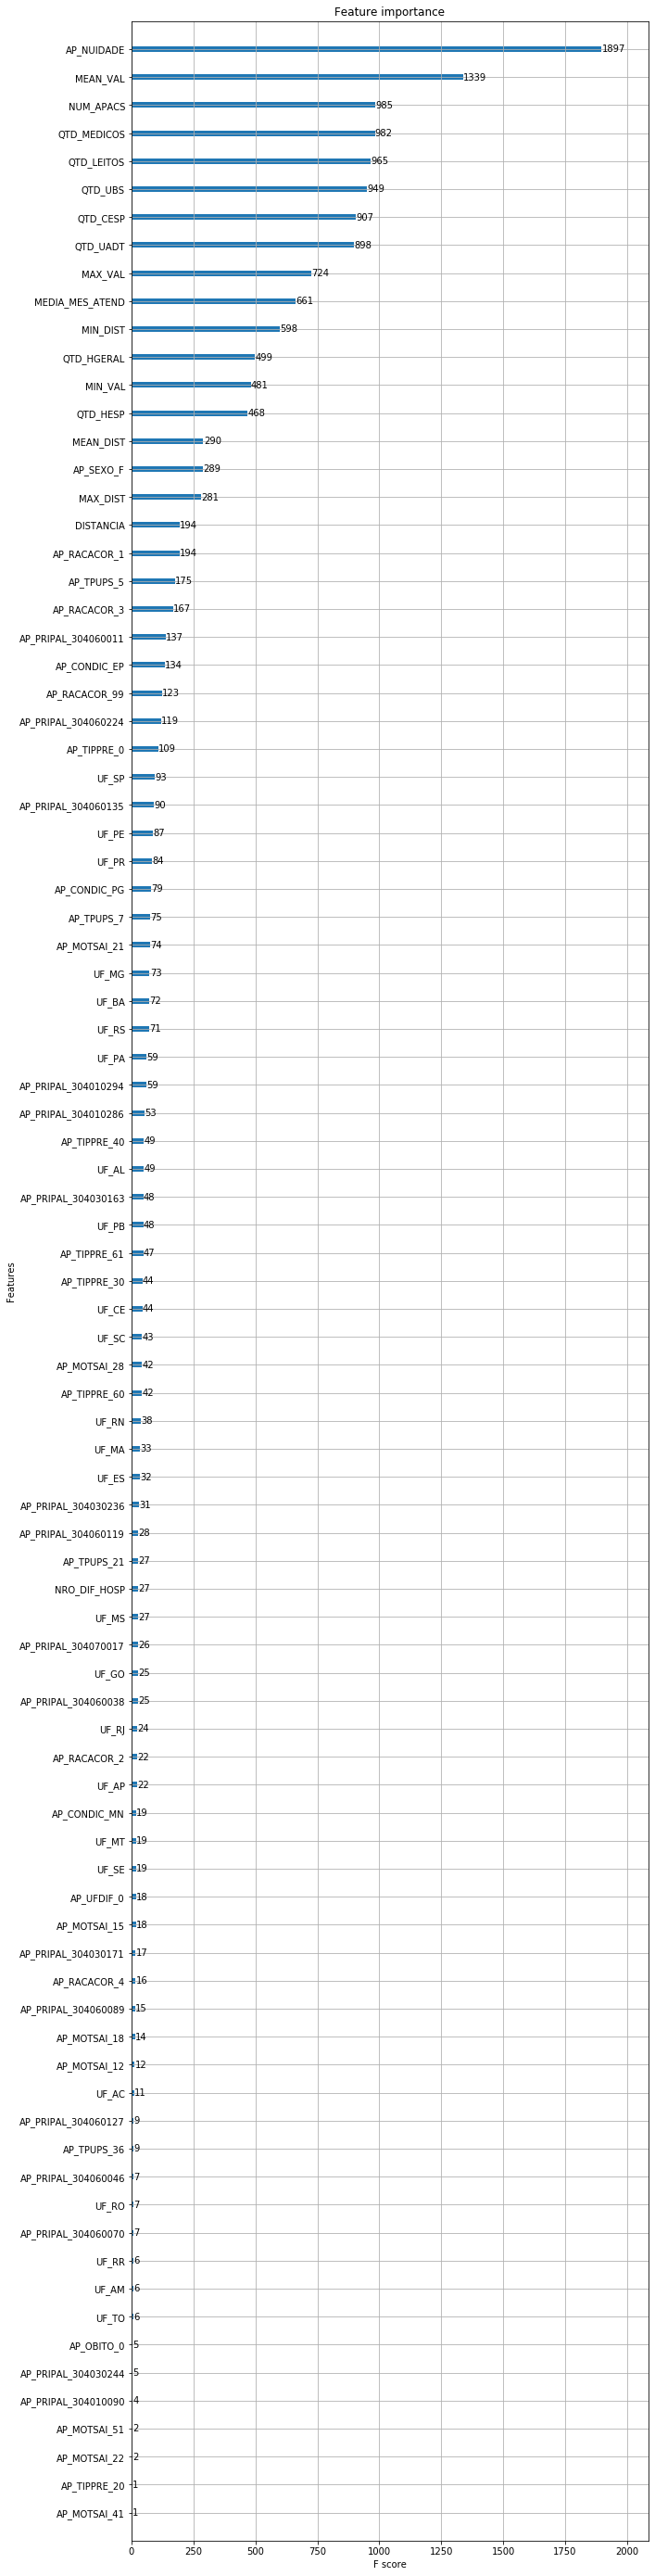

In [63]:
# Para peso
ax = xgb.plot_importance(bst, importance_type='weight')
fig = ax.figure
fig.set_size_inches(10, 50)